In [1]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


In [2]:
import pandas as pd
df = pd.read_excel('/content/drive/MyDrive/Colab Notebooks/hack24/Hackathon_Data.xlsx')

In [3]:
import pandas as pd

# Read the .xlsx file
xlsx_file = pd.ExcelFile('/content/drive/MyDrive/Colab Notebooks/hack24/Hackathon_Data.xlsx')

# Get the sheet names
sheet_names = xlsx_file.sheet_names

# Access the first sheet
df1 = xlsx_file.parse(sheet_names[0])



In [73]:
# Convert the 'DateAndHour' column to datetime format
df1['DateAndHour'] = pd.to_datetime(df1['DateAndHour'])

# Define the validation and test day ranges
validation_day_1 = pd.Timestamp('2024-03-26')
validation_day_2 = pd.Timestamp('2024-03-30')

# Create boolean masks to split the data
validation_data_1 = df1[df1['DateAndHour'].dt.date == validation_day_1.date()]
validation_data_2 = df1[df2['DateAndHour'].dt.date == validation_day_2.date()]

test_data = df1[(df1['DateAndHour'] > validation_day_1) & (df1['DateAndHour'] < validation_day_2) & (df1['DateAndHour'].dt.date != validation_day_1.date())]


# The rest of the data before validation_day_1 and after validation_day_2 is training data
training_data = df1[(df1['DateAndHour'] < validation_day_1)]

# Output sizes to check splits
(len(validation_data_1), len(validation_data_2), len(test_data), len(training_data))


(24, 24, 72, 8856)

In [6]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split, TimeSeriesSplit
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
# from bayes_opt import BayesianOptimization
import matplotlib.pyplot as plt



In [43]:
import pandas as pd
import numpy as np
from xgboost import XGBRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.preprocessing import StandardScaler
from tsfresh import extract_features
from tsfresh.feature_selection import select_features
from tsfresh.utilities.dataframe_functions import impute
import matplotlib.pyplot as plt

/usr/local/lib/python3.10/dist-packages/dask/dataframe/__init__.py:42: FutureWarning:


Dask dataframe query planning is disabled because dask-expr is not installed.

You can install it with `pip install dask[dataframe]` or `conda install dask`.
This will raise in a future version.




In [75]:
def create_features(df, freq='H'):
    df = df.copy()
    df['hour'] = df.index.hour
    df['dayofweek'] = df.index.dayofweek
    # df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    # df['year'] = df.index.year
    # df['dayofyear'] = df.index.dayofyear
    # df['dayofmonth'] = df.index.day
    # df['weekofyear'] = df.index.isocalendar().week
    df['is_weekend'] = np.where(df['dayofweek'] < 5, 0, 1)


    # df['lag_1'] = df['Load_data'].shift(1)
    # df['lag_24'] = df['Load_data'].shift(2)
    # df['lag_48'] = df['Load_data'].shift(24)
    # df['lag_196'] = df['Load_data'].shift(168)  # 1 week lag

    # df['rolling_mean_24'] = df['Load_data'].rolling(window=24).mean()
    # df['rolling_std_24'] = df['Load_data'].rolling(window=24).std()
    # df['rolling_mean_12'] = df['Load_data'].rolling(window=12).mean()
    # df['rolling_std_12'] = df['Load_data'].rolling(window=12).std()
    # df['rolling_mean_2'] = df['Load_data'].rolling(window=2).mean()
    # df['rolling_std_2'] = df['Load_data'].rolling(window=2).std()

    df['Temperature'] = df['Temperature'].diff()
    df['Temperature'].fillna(0, inplace=True)
    df['Temperature'] = df['Temperature'].cumsum()
    df['temp_moving_avg_3'] = df['Temperature'].rolling(window=3).mean()
    df['temp_moving_avg_6'] = df['Temperature'].rolling(window=6).mean()
    df['temp_moving_avg_12'] = df['Temperature'].rolling(window=12).mean()

    df['temp_lag1'] = df['Temperature'].shift(1)
    df['temp_lag24'] = df['Temperature'].shift(24)
    df['temp_diff'] = df['Temperature'] - df['temp_lag1']
    df['temp_diff24'] = df['Temperature'] - df['temp_lag24']
    df['temp_rolling_mean'] = df['Temperature'].rolling(window=24).mean()
    df['temp_rolling_std'] = df['Temperature'].rolling(window=24).std()
    df['temp_rolling_mean_12'] = df['Temperature'].rolling(window=12).mean()
    df['temp_rolling_std_12'] = df['Temperature'].rolling(window=12).std()



    # # Add Fourier terms for seasonality
    # for period in [24, 168, 8760]:  # Daily, Weekly, Yearly
    #     for order in [1, 3, 5]:  # Multiple orders for flexibility
    #         df[f'sin_{period}_{order}'] = np.sin(2 * np.pi * order * df.index.astype(int) / period)
    #         df[f'cos_{period}_{order}'] = np.cos(2 * np.pi * order * df.index.astype(int) / period)

    return df

In [77]:
# training_data.set_index('DateAndHour', inplace=True)
training_data = create_features(training_data)

In [78]:
# # 3. Split the data
# X = training_data.drop('Load_data', axis=1)
# y = training_data['Load_data']

# # Convert 'object' columns to numeric
# X = X.apply(pd.to_numeric, errors='coerce')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)


X_train = training_data.drop('Load_data', axis=1)
y_train = training_data['Load_data']

# Convert 'object' columns to numeric
X_train = X_train.apply(pd.to_numeric, errors='coerce')
# X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=False)

In [79]:
model = XGBRegressor(n_estimators=1000, learning_rate=0.01, random_state=42, colsample_bylevel=0.8, colsample_bytree=0.8)
model.fit(X_train, y_train)

XGBRegressor(base_score=None, booster=None, callbacks=None,
             colsample_bylevel=0.8, colsample_bynode=None, colsample_bytree=0.8,
             device=None, early_stopping_rounds=None, enable_categorical=False,
             eval_metric=None, feature_types=None, gamma=None, grow_policy=None,
             importance_type=None, interaction_constraints=None,
             learning_rate=0.01, max_bin=None, max_cat_threshold=None,
             max_cat_to_onehot=None, max_delta_step=None, max_depth=None,
             max_leaves=None, min_child_weight=None, missing=nan,
             monotone_constraints=None, multi_strategy=None, n_estimators=1000,
             n_jobs=None, num_parallel_tree=None, random_state=42, ...)

In [80]:
# test_data.set_index('DateAndHour', inplace=True)
test_data = create_features(test_data)


In [81]:
X_test = test_data.drop('Load_data', axis=1)
y_test = test_data['Load_data']

# Convert 'object' columns to numeric
X_test = X_test.apply(pd.to_numeric, errors='coerce')

Root Mean Squared Error: 87.41154736535574


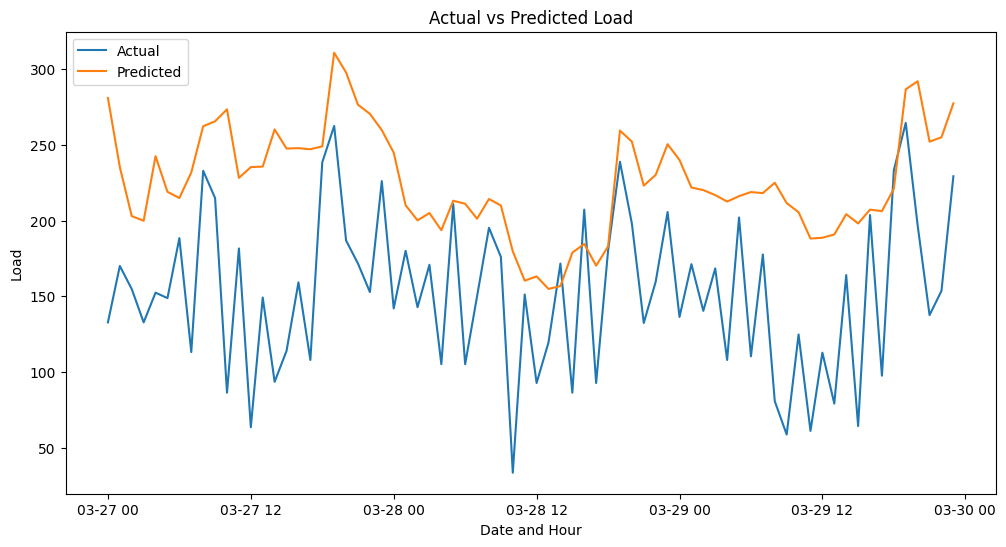

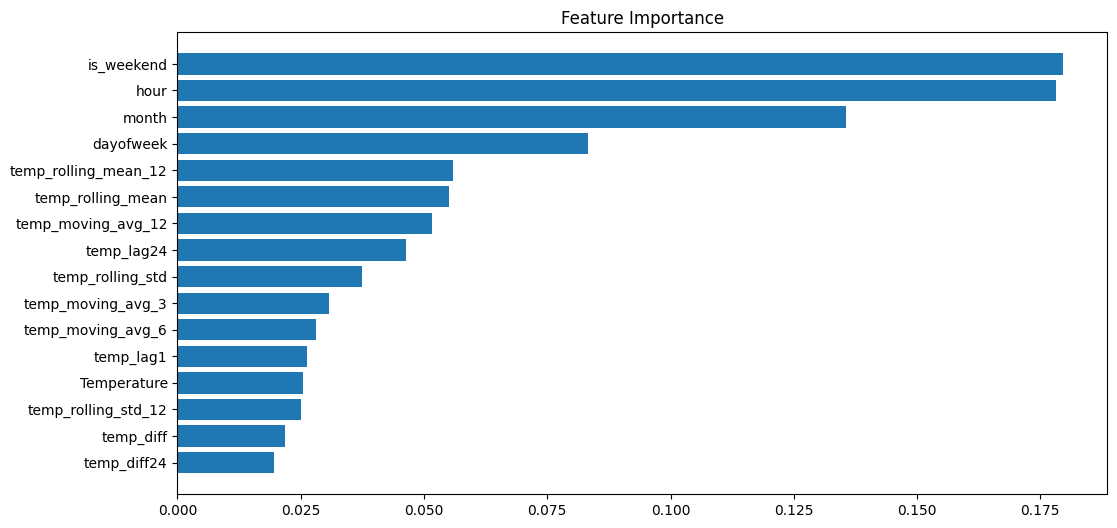

In [82]:
# 5. Make predictions
y_pred = model.predict(X_test)

# 6. Evaluate the model
mse = mean_squared_error(y_test, y_pred)
rmse = np.sqrt(mse)
print(f"Root Mean Squared Error: {rmse}")

# Plot actual vs predicted values
plt.figure(figsize=(12, 6))
plt.plot(y_test.index, y_test.values, label='Actual')
plt.plot(y_test.index, y_pred, label='Predicted')
plt.legend()
plt.title('Actual vs Predicted Load')
plt.xlabel('Date and Hour')
plt.ylabel('Load')
plt.show()

# Feature importance
feature_importance = model.feature_importances_
sorted_idx = np.argsort(feature_importance)
pos = np.arange(sorted_idx.shape[0]) + .5
plt.figure(figsize=(12, 6))
plt.barh(pos, feature_importance[sorted_idx], align='center')
plt.yticks(pos, X_test.columns[sorted_idx])
plt.title('Feature Importance')
plt.show()


In [64]:
import plotly.graph_objects as go

# Assuming y_test is a Pandas Series with a DateTimeIndex
fig = go.Figure()

fig.add_trace(go.Scatter(
    x=y_test.index,
    y=y_test.values,
    mode='lines',
    name='Actual'
))

fig.add_trace(go.Scatter(
    x=y_test.index,  # Assuming y_pred has the same index as y_test
    y=y_pred,
    mode='lines',
    name='Predicted'
))

fig.update_layout(
    title='Actual vs Predicted Load',
    xaxis_title='Date and Hour',
    yaxis_title='Load'
)

fig.show()

In [ ]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error

# Define a safe MAPE calculation function
def safe_mape(true_values, predicted_values):
    mask = true_values != 0  # Ignore true values that are zero
    return np.mean(np.abs((true_values[mask] - predicted_values[mask]) / true_values[mask])) * 100

mape = safe_mape(y_test, y_pred)

print(f"Mean Absolute Percentage Error (MAPE): {mape}")